In [324]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [325]:
import os
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm, Normalize, ListedColormap
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches


In [326]:
global RunID 
global Path
RunID = "CV_BASE_DEFINITIVO_LOW"
pathTXT = fr'..\Stats\{RunID}\TestLog'
# path = r"..\Stats\Grafici\TestLog\W Refactoring (Environment)\AgentStats.txt"



In [327]:
def heatmap(df,bg,env):
    plt.figure() 
    map_img = mpimg.imread(bg)  
    df['X'] = (df['X'] * 10).astype(int)  + 100 
    df['Z'] = (df['Z'] * 10).astype(int) + 100 
    arX = df['X'].to_numpy() 
    arZ = df['Z'].to_numpy() 
 
    heatmap = np.zeros((200, 200)) 
    for j in range (0, len(arX)): 
        heatmap[arZ[j]][arX[j]] = heatmap[arZ[j]][arX[j]] + 1 
    h = sns.heatmap(heatmap, alpha =0.3, # whole heatmap is translucent 
            annot = False, 
            zorder = 3,) 
    h.invert_yaxis() 
 
    h.imshow(map_img, 
          aspect = h.get_aspect(), 
          extent = h.get_xlim() + h.get_ylim(), 
          zorder = 1, alpha = 0.40) 


In [328]:
def linea_zoom(myData: pd.DataFrame, bg, env):
    plt.figure()
    img = plt.imread(bg) 
    fig, ax = plt.subplots()
    ax.imshow(img, extent=[-10, 10, -10, 10])
    plt.xlabel('X [m]')
    plt.ylabel('Z [m]')
    red = myData[myData["Group"] == "First"]
    blue = myData[myData["Group"] == "Second"]
    green = myData[myData["Group"] == "Third"]
    Xr = red["X"].explode().values
    Zr = red["Z"].explode().values
    Xb = blue["X"].explode().values
    Zb = blue["Z"].explode().values
    Xg = green["X"].explode().values
    Zg = green["Z"].explode().values
    plt.scatter(Xr, Zr, s=0.5, color="red", rasterized=True, alpha=0.5)
    plt.scatter(Xb, Zb, s=0.5, color="blue", rasterized=True, alpha=0.5)
    plt.scatter(Xg, Zg, s=0.5, color="green", rasterized=True, alpha=0.5)
    
    plt.suptitle(f"Percorso agenti: {env} - Modello : {RunID}")
    legend_items = []
    if not red.empty:
        # Crea un patch con un marker rosso
        red_patch = mpatches.Patch(color='red', label='First Group')
        legend_items.append(red_patch)

    if not blue.empty:
        # Crea un patch (pezzo di legenda) con un marker blu
        blue_patch = mpatches.Patch(color='blue', label='Second Group')
        legend_items.append(blue_patch)

  
    if not green.empty:
        # Crea un patch con un marker verde
        green_patch = mpatches.Patch(color='green', label='Third Group')
        legend_items.append(green_patch)

    # Aggiungi i patch alla legenda
    plt.legend(handles=legend_items)

    plt.xlabel('X [m]')
    plt.ylabel('Z [m]')

    #plt.savefig(f'..\Stats\{RunID}\TestLog\{env}\{env}_{RunID}_graficoLineaZoom.svg', format='svg', transparent=True)


In [329]:
def speed_travel_stats(myData: pd.DataFrame, colName: str, myName: str) -> pd.DataFrame:
    _ = plt.figure()

    """Calcola varie statistiche del dataframe

    Arguments:
    myData -- myData è il dataframe su cui calcolare le statistiche
    colName -- colName è il nome della colonna del dataframe su cui calcolare le statistiche
    myName -- myName è il nome che viene dato al dataframe restitutio
    ...
    Returns:
    DataFrame -- dataframe contenente le statistiche sulla colonna colName del dataframe myData
    """
    all_statistica = myData[colName].values
    n_agenti = len(all_statistica)
    ### myData["realSpeeds"].values è una lista di liste, la vado quindi ad appiattire
    ### myData["travelDistance"].values NON è una lista di liste, quindi non va modificata

    ### Oltre ad appiattire vado a fare la media del dato, in quanto voglio sapere le varie statitiche sulla media
    ### Es. se non facessi la media, min(speed) sarebbe sempre 0 e max(speed) = 1.7
    ### Così invece vedo le varie statische sulla velocità media
    # if type(all_statistica[0]) == list:
    #     all_statistica = [statistics.mean(item) for item in all_statistica]

    my_dict = {
        "Nome": myName,
        "Mean": statistics.mean(all_statistica),
        "MeanDesired": statistics.mean(myData["speedDes"].values),
        "Median": statistics.median(all_statistica),
        "SD": statistics.stdev(all_statistica),
        "min": min(all_statistica),
        "max": max(all_statistica),
        "n": n_agenti
    }

    dataframe_appoggio = pd.DataFrame([my_dict])
    dataframe_appoggio.set_index("Nome", inplace=True)
    return dataframe_appoggio

In [330]:
def lineaPercorso(myData: pd.DataFrame, my_cmap,bg, env):
    plt.figure()
    """
    Crea e salva un plot che mostra il percorso degli agenti

    Arguments:
    myData -- myData è il dataframe su cui calcolare il grafico
    myName -- myName è il nome che mostrato nel grafico e con cui viene salvato il file
    ...
    Returns:
    Salva il plot che mostra il percorso degli agenti nella cartella dei grafici
    """
    _ = plt.figure()
    plt.suptitle("Agents' path: ")
    plt.xlabel('X [m]')
    plt.ylabel('Z [m]')

    ### Prendo i valori di X,Z del dataframe
    ### Trasformo la lista di liste in una lista unica
    X = myData["X"].explode().values.astype(float)
    Z = myData["Z"].explode().values.astype(float)

    area = int((int(max(X)) - int(min(X))) * (int(max(Z)) - int(min(Z))) / 2)

    ### Faccio l'histogramma2d e applico il gaussian filter
    heatmap, xedges, yedges = np.histogram2d(X, Z, bins=45)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    img = plt.imread(bg) 
    plt.imshow(img, extent=[-10, 10, -10, 10])

    # img = gaussian_filter(heatmap, sigma=8).T
    img = heatmap.T

    plt.imshow(img, extent=extent, origin='lower', cmap=my_cmap )
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])


In [331]:
def nuovo(myData: pd.DataFrame, my_cmap,bg, env):
    _ = plt.figure()

    for i in [1,2,3,5]:
        _ = plt.figure()
        plt.suptitle("Agents' average speed [m/s] in sp")
        plt.xlabel('X [m]')
        plt.ylabel('Z [m]')
        img = plt.imread(bg) 
        plt.imshow(img, extent=[-10, 10, -10, 10])

        ### Prendo i valori di X, Z e RealSpeeds del dataframe
        ### Trasformo la lista di liste in una lista unica
        X = myData["posX"].explode().values.astype(float)
        Z = myData["posZ"].explode().values.astype(float)
        Spe = myData["speed"].explode().values.astype(float)

        prec = i

        X = [round(a * prec) / prec for a in X]
        Z = [round(a * prec) / prec for a in Z]

        df = pd.DataFrame({"X": X, "Z": Z, "S": Spe})

        prova = (df.groupby(["X", "Z"]).mean()).reset_index()
        prova2 = df.groupby(["X", "Z"]).mean().unstack()

        plt.imshow(np.array(prova2.fillna(0)).T, extent=[min(X), max(X), min(Z), max(Z)], origin='lower', cmap=my_cmap)

        plt.xlim([-10, 10])
        plt.ylim([-10, 10])
        plt.colorbar()
        plt.savefig(f'../../../LogTraining/{RunID}/Ambienti-Grafici/{env}/{env}_{RunID}_graficonuovo{i}.svg', format='svg', transparent=True)

    # _ = plt.figure()
    # plt.suptitle(f"Agents' average speed in space: {myName}")
    # plt.xlabel('X [m]')
    # plt.ylabel('Z [m]')
    # img = plt.imread(f"Sfondi/{nome}.png")
    # plt.imshow(img, extent=[-10, 10, -10, 10])
    # plt.scatter(prova["X"], prova["Z"], c=prova["S"], cmap="jet2")
    # plt.xlim([-10, 10])
    # plt.ylim([-10, 10])
    # plt.colorbar()
    # plt.savefig(f'Grafici/{nome}/{myName}_speed2.png', bbox_inches='tight', pad_inches=0.1)



In [332]:
def lineaSpeed(myData: pd.DataFrame, bg, env):
    """
    Crea e salva un plot che mostra la velocità media degli agenti nello spazio

    Arguments:
    myData -- myData è il dataframe su cui calcolare il grafico
    myName -- myName è il nome che mostrato nel grafico e con cui viene salvato il file
    ...
    Returns:
    Salva il plot che mostra la velocità media degli agenti nello spazio nella cartella dei grafici
    """
    _ = plt.figure()
    img = plt.imread(bg) 
    fig, ax = plt.subplots()
    ax.imshow(img, extent=[-10, 10, -10, 10])
    #_ = plt.figure()
    myData = myData.sort_values('Speed', ascending=False)
    ### Prendo i valori di X, Z e RealSpeeds del dataframe
    ### Trasformo la lista di liste in una lista unica
    X = myData["X"].explode().values.astype(float)
    Z = myData["Z"].explode().values.astype(float)
    Spe = myData["Speed"].explode().values.astype(float)


    plt.scatter(X, Z,s=0.5, c=Spe, cmap='cool', alpha=0.7)
    
      # Aggiungi una barra di colore come legenda
    cbar = plt.colorbar()
    cbar.set_label('Intensita velocita')
    
    plt.suptitle(f"Velocita' agenti: {env} - Modello : {RunID}")
    plt.xlabel('X [m]')
    plt.ylabel('Z [m]')
    

 

In [333]:
def histoConfrontoSpeed(myData: pd.DataFrame,bg, env):
    """
    Crea e salva un istogramma che confronta la velocità reale (media) con quella desiderata

    Arguments:
    myData -- myData è il dataframe su cui calcolare il grafico
    myName -- myName è il nome che mostrato nel grafico e con cui viene salvato il file
    ...
    Returns:
    Salva l'istogramma che che confronta la velocità reale (media) con quella desiderata nella cartella dei grafici
    """
    _ = plt.figure()

    plt.suptitle("Comparison between Actual speed and Desired speed:")
    plt.xlabel('Speed [m/s]')
    plt.ylabel('% of agents')

    Spe = myData["speed"]
    DSpe = myData["desiredSpe"]

    ### I pesi servono ad avere sull'asse y la percentuale
    pesi = np.ones(len(Spe)) / len(Spe)

    ### I bins rappresentano la granularità dell'istogramma
    bins = np.arange(0, 1.8, 0.05)

    plt.hist(Spe, color=[(0, 0, 1, 0.5)], weights=pesi, bins=bins)
    plt.hist(DSpe, color=[(1, 0, 0, 0.5)], weights=pesi, bins=bins)
    plt.gca().legend(('Actual speed', 'Desired speed'), loc="upper left")
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.savefig(f'../../../LogTraining/{RunID}/Ambienti-Grafici/{env}/{env}_{RunID}_graficoHistoConfrontoSpeed.svg', format='svg', transparent=True)


In [334]:
def fondamentale(myData: pd.DataFrame, coords: list):
    """
    Crea e salva il diagramma fondamentale

    Arguments:
    myData -- myData è il dataframe su cui calcolare il grafico
    coords -- coordinate su cui calcolare il diagramma fondamentale
    ...
    Returns:
    Salva il diagramma fondamentale nella cartella dei grafici
    """

    ### Prendo i valori di X, Z, Spe e Timestamp del dataframe
    ### Trasformo la lista di liste in una lista unica
    X = myData["X"].explode()
    Z = myData["Z"].explode()
    Spe = myData["Speed"].explode()
    Timestamp = myData["Time"].explode()

    ### Creo delle liste di appoggio, in cui salvare solo i dati utili
    Spei, Timestampi = [], []

    ### Creo un df con solo i dati presi all'interno coordinate specificate
    for i in range(len(X)):
        if coords[0] <= X[i] <= coords[1] and coords[2] <= Z[i] <= coords[3]:
            Spei.append(Spe[i])
            Timestampi.append(Timestamp[i])
    df_big = pd.DataFrame({"Spe": Spei, "Timestamp": Timestampi})

    area = (coords[1] - coords[0]) * (coords[3] - coords[2])
    ### Il numero di agenti è uguale al count degli agenti ad ogni frame (raggruppando per "Timestamp")
    numeroAgenti = df_big.groupby("Timestamp").count() / area
    ### La speed media degli agenti è la mean della speed ad ogni frame (raggruppando per "Timestamp")
    speedAgenti = df_big.groupby("Timestamp").mean()

    finale = pd.concat([numeroAgenti, speedAgenti], axis=1)

    ### finale è un DF che, per ogni frame ha il numero di agenti (X) e la speed (Y)
    finale.columns = ["X", "Y"]
    finale = finale[finale["X"] * area < 7]

    ### La linea rossa è la media della speed gruppando per numero di agenti (vedo la speed media quando ho n agenti)
    linea = finale.groupby("X").mean()
    ### linea è un DF che per ogni numero possibile di agenti (index) ha la loro speed media (Y)

    fig, ax = plt.subplots(constrained_layout=True)
    ### Plotto i puntini
    ax.scatter(finale["X"], finale["Y"], s=1, color=(0, 0, 0, 0.2), rasterized=True)
    ### Plotto la linea
    ax.plot(linea.index, linea["Y"], marker='o', c="red", markersize=5)
    ax.set_xlabel('Density [1/m$^2$]')
    ax.set_ylabel('Average speed [m/s]')
    ax.set_title(f"Fundamental graph")

    def mulArea(x):
        return x * area

    secax = ax.secondary_xaxis('top', functions=(mulArea, mulArea))
    secax.set_xlabel('N°Agents')

    # plt.savefig(f'Grafici/{nome}/Fondamentale.png', bbox_inches='tight', pad_inches=0.1, dpi=300)



In [335]:
def fondamentaleMIO(df, env): 
    dict = {'speed':[], 'count':[],}
    new_df = pd.DataFrame(dict)
    removedIteration = 5
    df = df.dropna()
    df = df[df['iteration'] >= removedIteration]
    mask=pd.DataFrame()
    unique_envId = df['EnvID'].unique()
    for id in unique_envId:
        filtered_df = df[df['EnvID'] == id]
        max_iteration_number = filtered_df["iteration"].max() 
        for i in range(removedIteration + 1, max_iteration_number - 3): 
            mask = filtered_df[filtered_df['iteration'] == i]
            for index, row in mask.iterrows():
                count = 0
                for index2, row2 in mask.iterrows():
                    if ((row['X'] - row2['X'] <= 0.5) & (row['Z'] - row2['Z'] <= 0.5)):
                        count += 1 
                # Aggiungere la nuova riga al DataFrame esistente
                new_df.loc[len(new_df.index)] = [row['Speed'], count]
    
    

    mean_speed_per_count = new_df.groupby('count')['speed'].mean().reset_index()


    # First plot: Scatterplot
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(x='count', y='speed', data=new_df, palette='coolwarm', s=2)  # plot for all points
    sns.scatterplot(x='count', y='speed', data=mean_speed_per_count, color='black', s=20, marker='D', ax=ax)  # plot for mean points
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


    # Connecting mean points with a line
    plt.plot(mean_speed_per_count['count'], mean_speed_per_count['speed'], color='red') 
    plt.suptitle(f"Grafico fondamentale ': {env} - Modello : {RunID}")


    plt.show()
    # Second plot: KDE plot using displot (note: displot does not use ax=, so we use plt.subplot)
    sns.displot(new_df, x="speed", hue="count", kind="kde", fill=True, palette='coolwarm')
    plt.suptitle(f"Densita velocita' ': {env} - Modello : {RunID}")

    plt.show()
    

    
        

In [336]:
def densityPlot(df, bg, env):
    timestep_str = df["timestamp"] #extracting time
    time = timestep_str.astype(np.int) #converting from string to float
    timeArr = time.values

    count_arr = np.bincount(timeArr)
    for j in range(len(count_arr)-1,-1,-1):
        if(count_arr[j] == 0):
            count_arr[j] = count_arr[j+1]
    
    x = list(range(0,len(count_arr)))
    plt.plot(x,count_arr)

    plt.xlabel('Time timesteps')
    plt.ylabel('Agents in corridor')
    plt.title('Density in corridor')
    plt.legend(loc="upper right")


In [337]:
def timePlot(df, bg,env):
    time_str = df["time"] #extracting time
    time = time_str.astype(np.float) #convert from string to float
    timeArr = time.values
    out = []
    current = (timeArr[0])
    out.append(int(current))
    for el in timeArr:
        if el!=current:
            out.append(int(el))
            current = el
    plt.boxplot(out)
    # plt.boxplot(out, labels='couple')
    plt.xlabel('Data series')
    plt.ylabel('timesteps')
    plt.title('Time to finish env')
    plt.legend(loc="upper right")
    plt.savefig(f'../../../LogTraining/{RunID}/Ambienti-Grafici/{env}/{env}_{RunID}_graficotimePlot.svg', format='svg', transparent=True)


In [338]:
def speedPlot(df,bg,env):
    bins = np.arange(0, 1.8, 0.05) #setting up the bins in graph
    speed_str = df["speed"] #extracting speed
    speed = speed_str.astype(np.float) #converting from string to float
    plt.hist(speed, histtype='stepfilled', alpha=0.3,bins=bins, color='red', label='red')

    plt.xlabel('Speed')
    plt.ylabel('Frequency')
    plt.title('Steps at speed')
    plt.yscale("log")
    plt.legend(loc="upper right")
    # plt.savefig(f'../../../LogTraining/{RunID}/Ambienti-Grafici/{env}/{env}_{RunID}_graficoSpeedPlot.svg', format='svg', transparent=True)

In [339]:
def anglePlot(df,bg,env): 
     
    angle = df['Angle'].astype(int)
    angle = np.radians(angle)

    plt.figure(figsize=(8,8))

    ax = plt.subplot(111, polar=True)

    width = 2*np.pi / 360
    height= []
    for x in angle:
        height.append(np.count_nonzero(angle==x))

    # Draw bars
    bars = ax.bar(
        x=angle, 
        height=height, 
        width=width, 
        bottom=0,
        linewidth=1, 
        edgecolor="blue")
    
    plt.suptitle(f"Istogramma frequenza angoli: {env} - Modello : {RunID}")

    plt.show()



<Figure size 640x480 with 0 Axes>

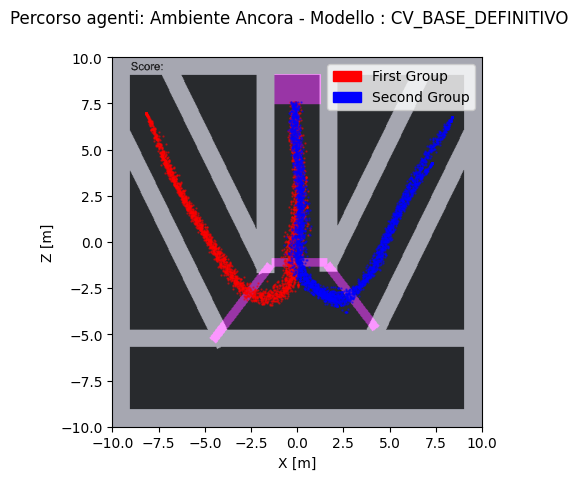

<Figure size 640x480 with 0 Axes>

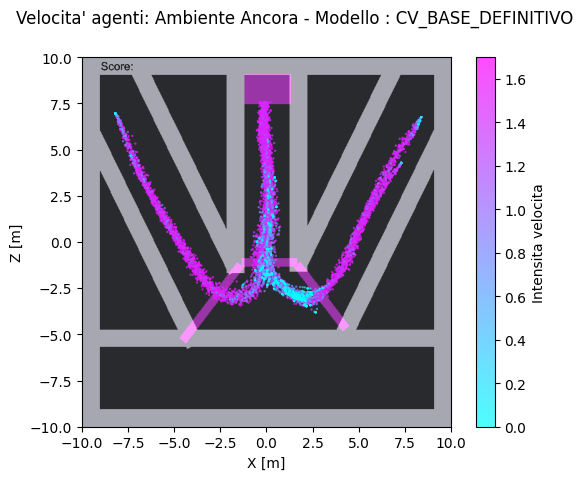

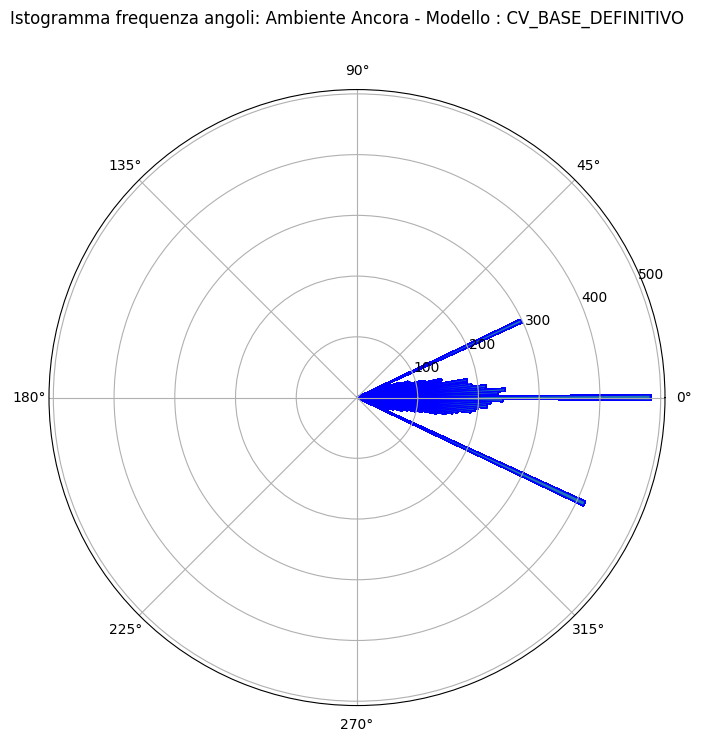

<Figure size 640x480 with 0 Axes>

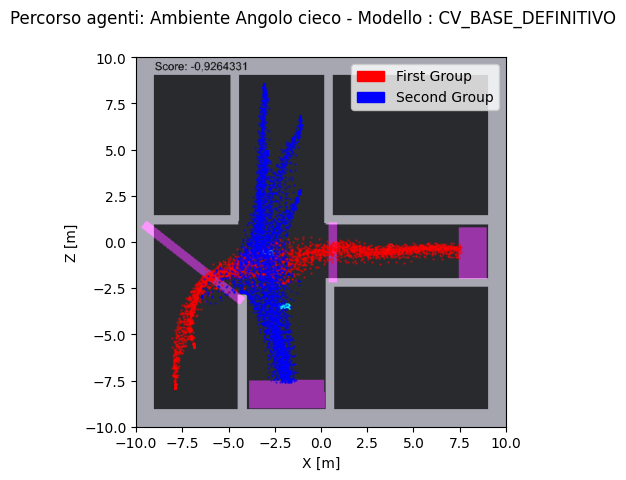

<Figure size 640x480 with 0 Axes>

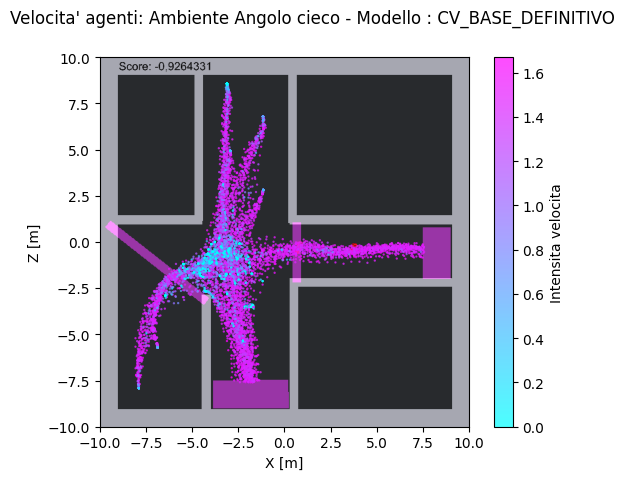

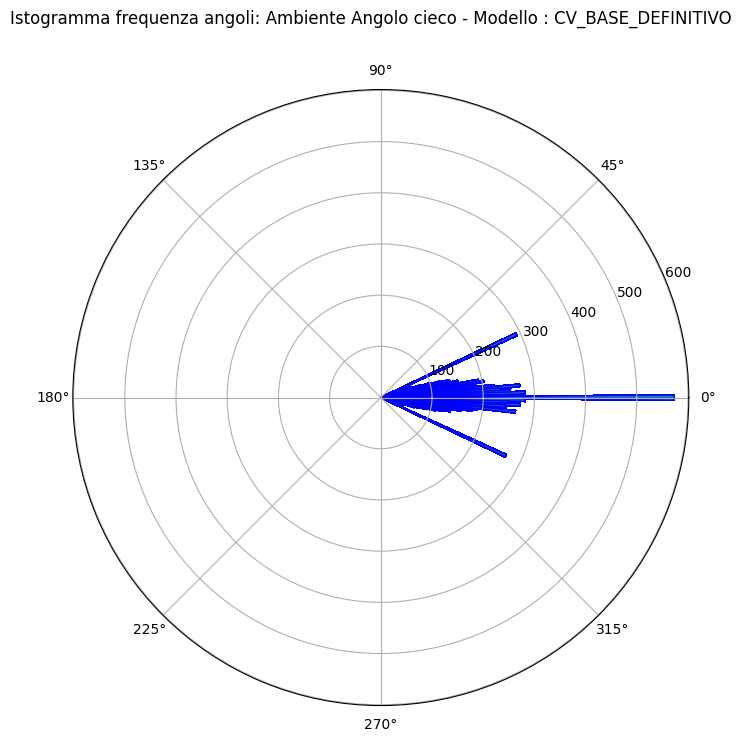

<Figure size 640x480 with 0 Axes>

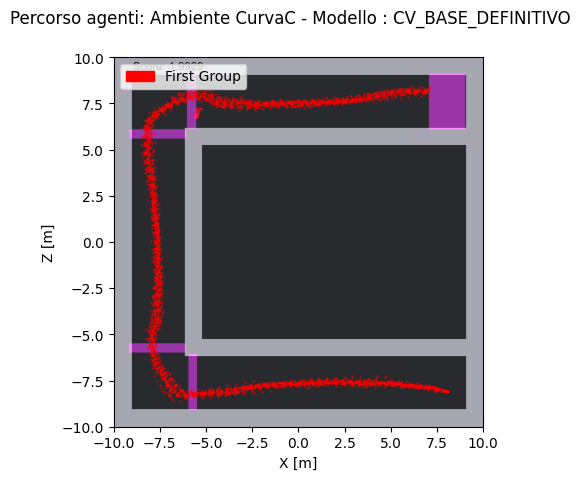

<Figure size 640x480 with 0 Axes>

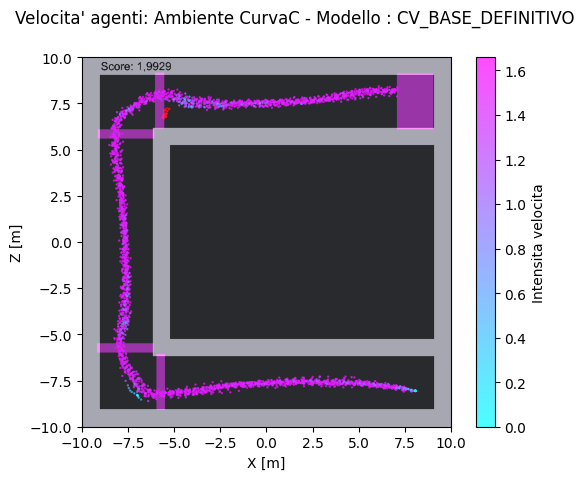

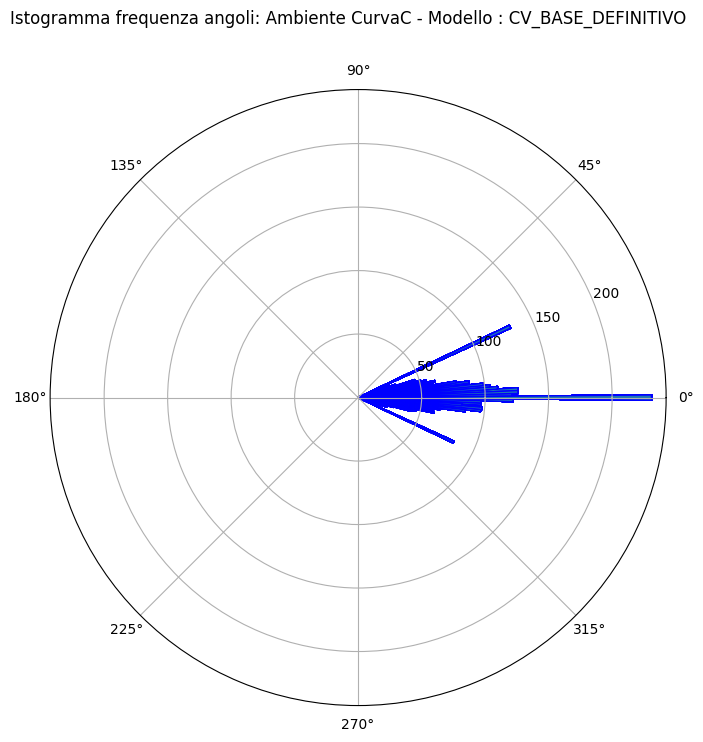

<Figure size 640x480 with 0 Axes>

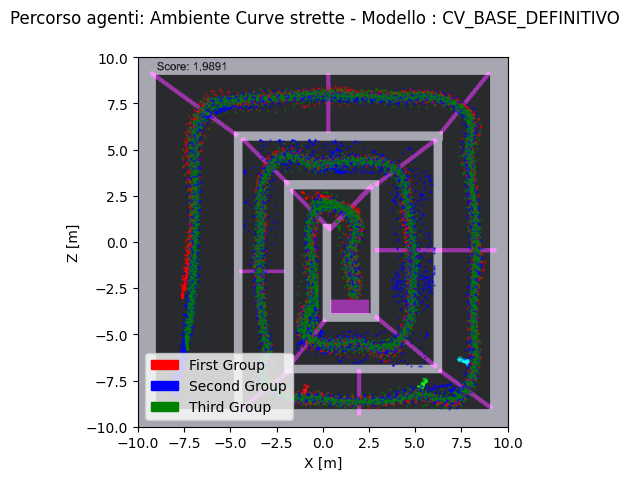

<Figure size 640x480 with 0 Axes>

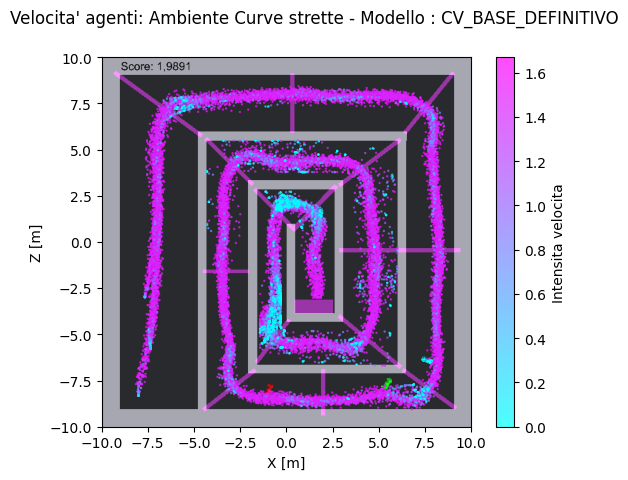

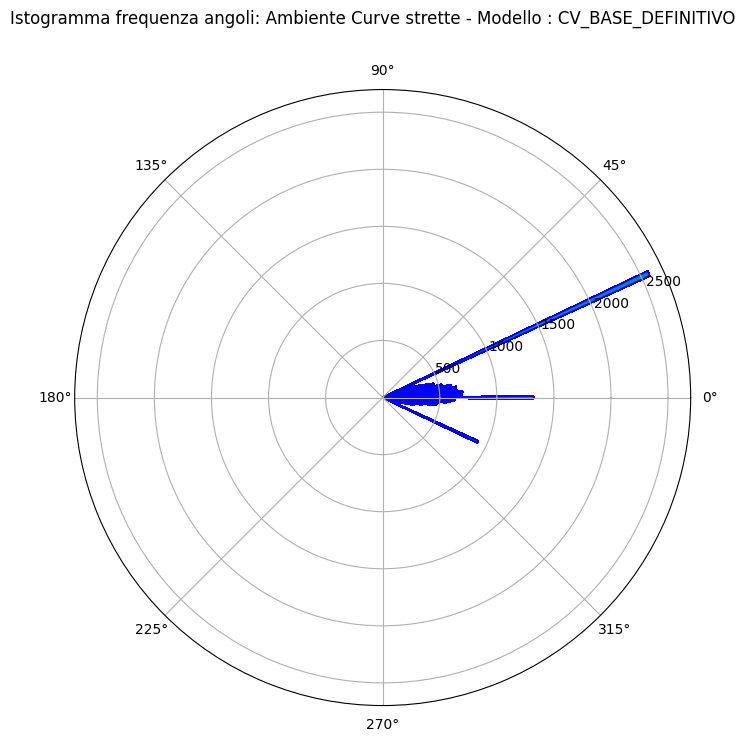

<Figure size 640x480 with 0 Axes>

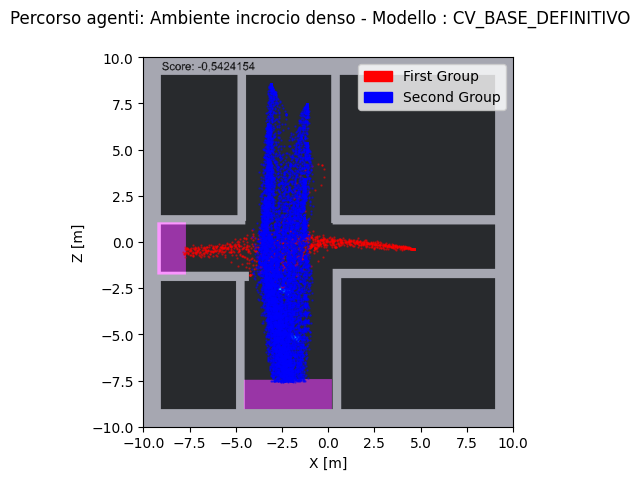

<Figure size 640x480 with 0 Axes>

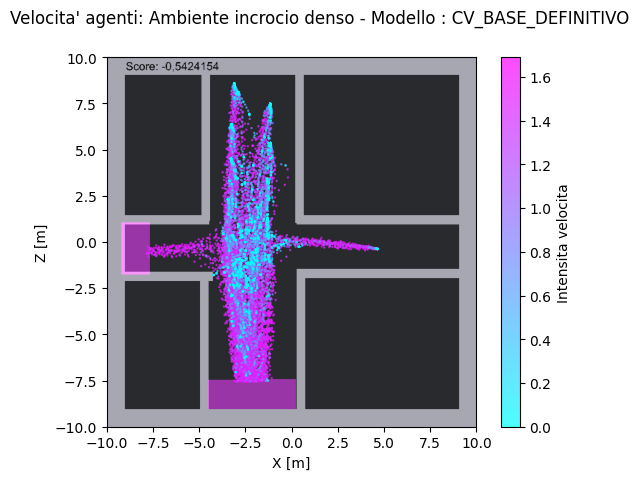

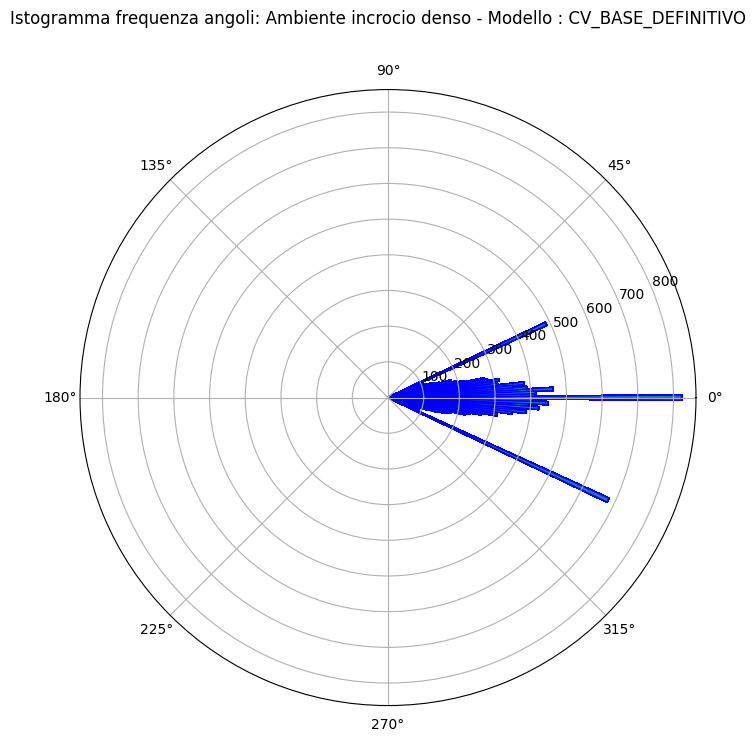

<Figure size 640x480 with 0 Axes>

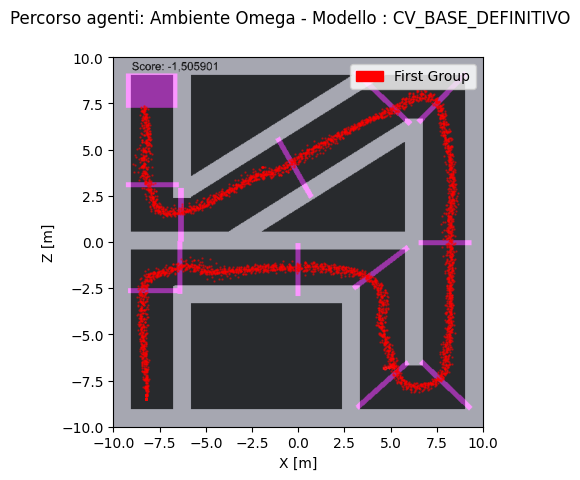

<Figure size 640x480 with 0 Axes>

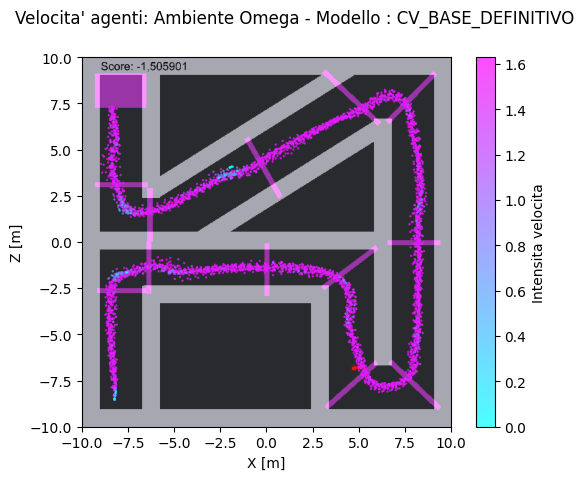

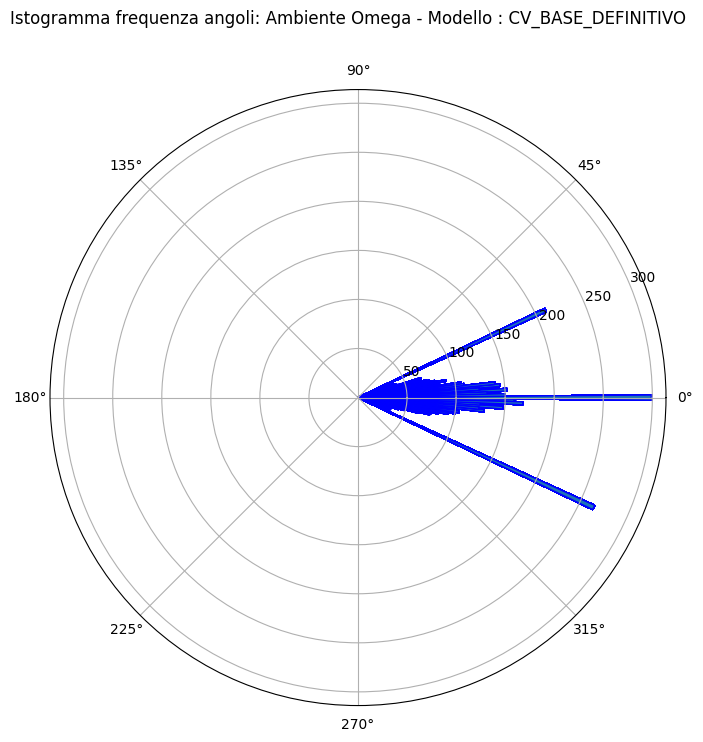

<Figure size 640x480 with 0 Axes>

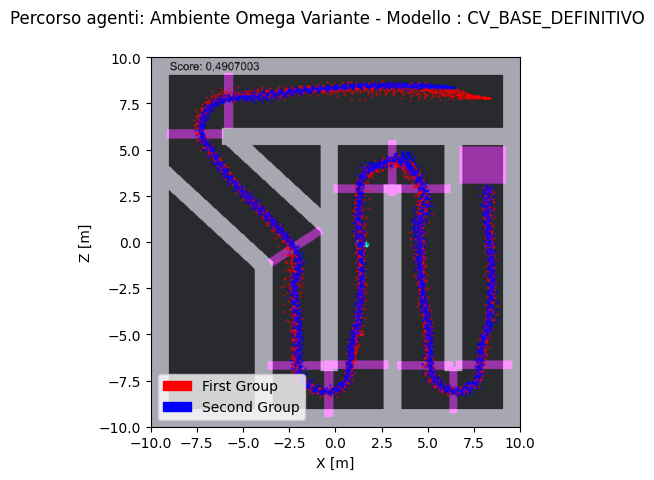

<Figure size 640x480 with 0 Axes>

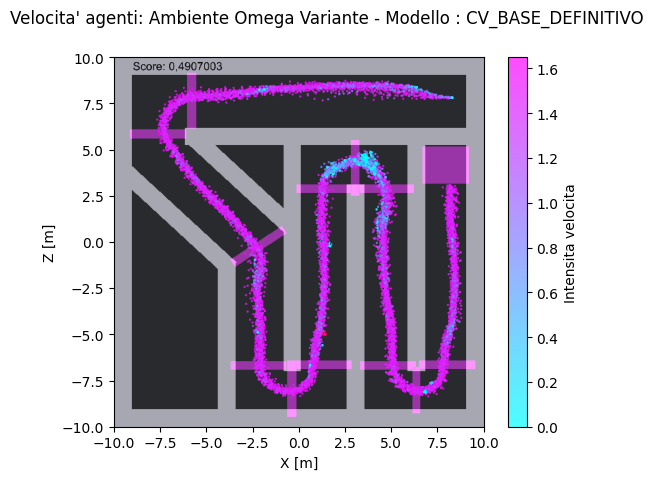

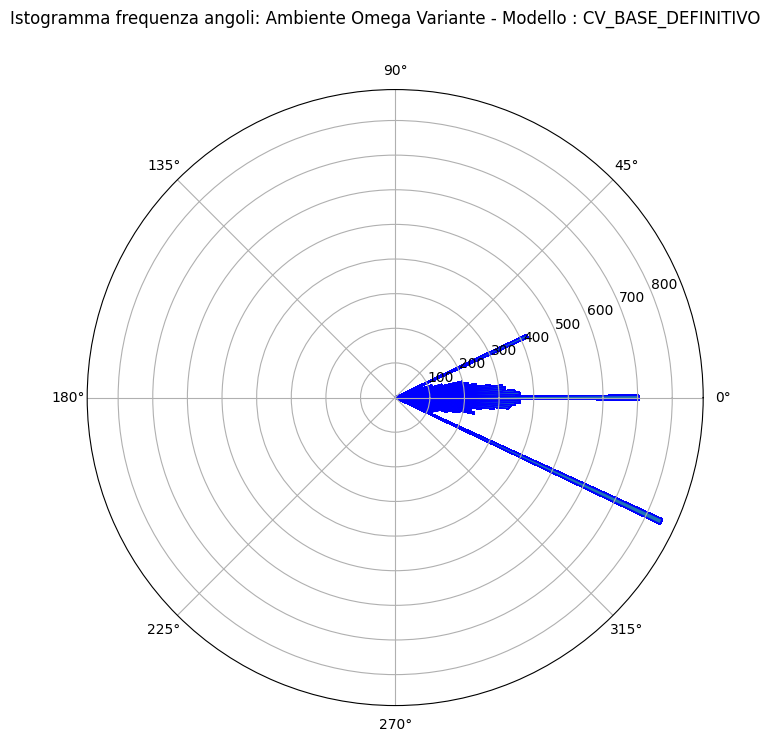

<Figure size 640x480 with 0 Axes>

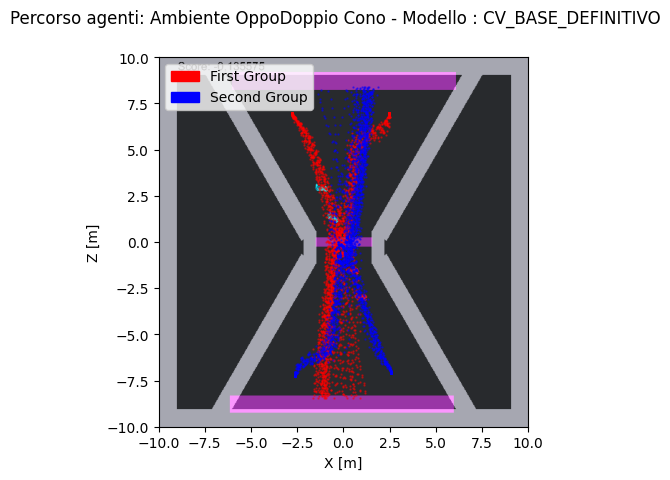

<Figure size 640x480 with 0 Axes>

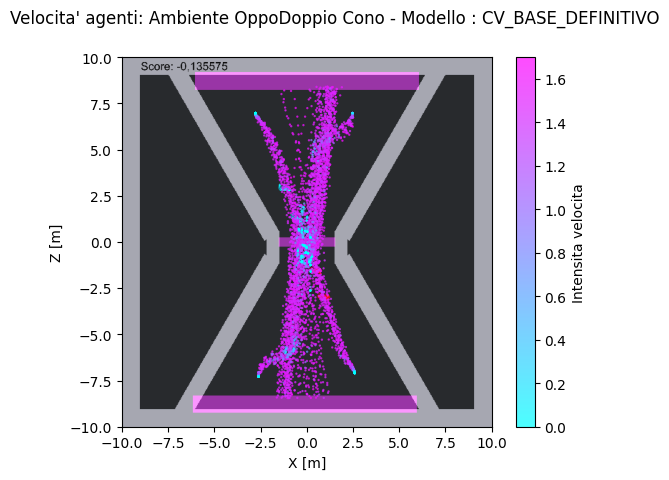

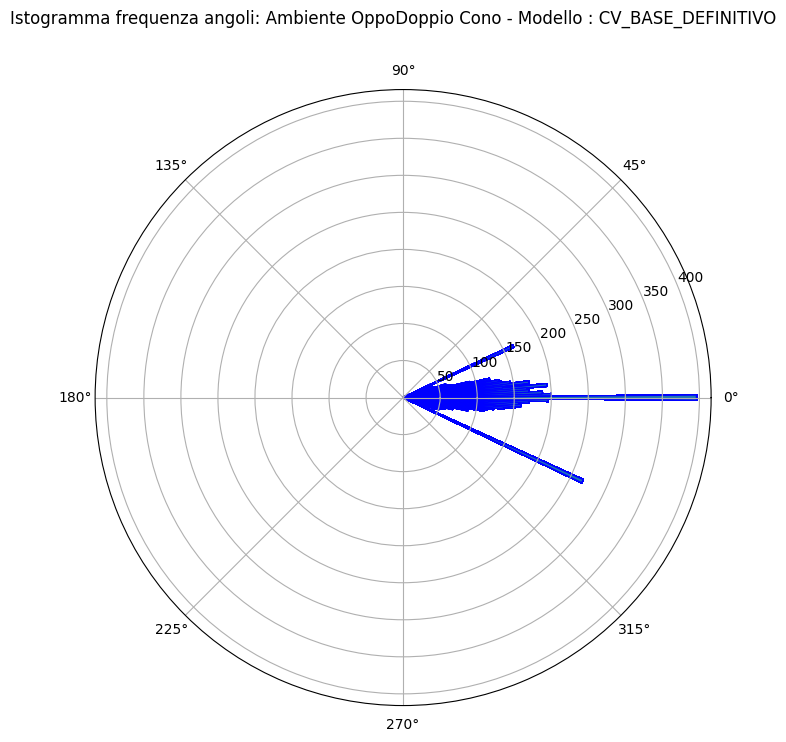

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

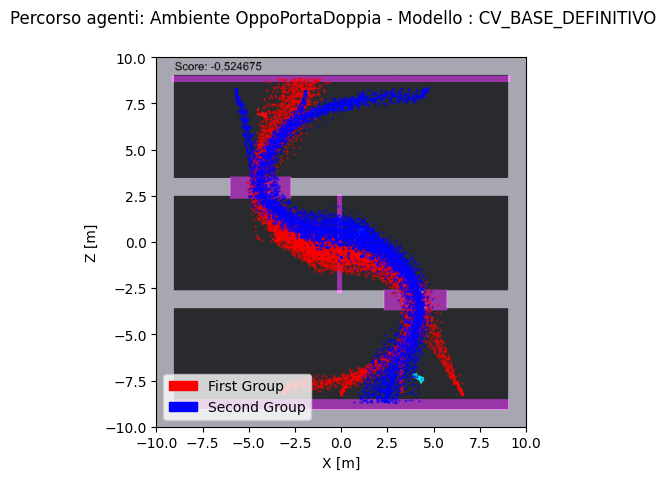

<Figure size 640x480 with 0 Axes>

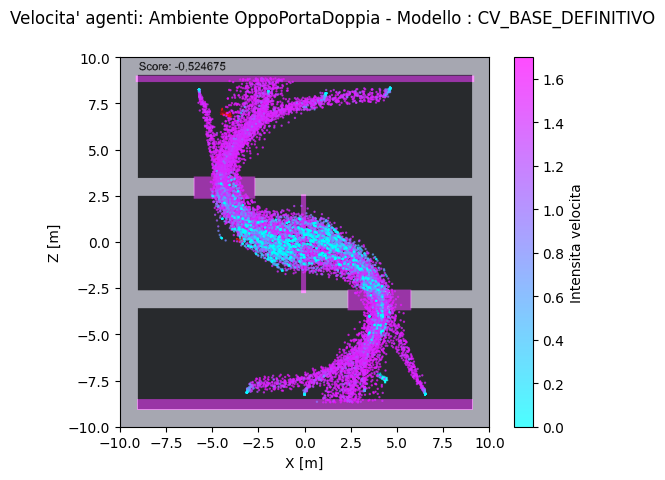

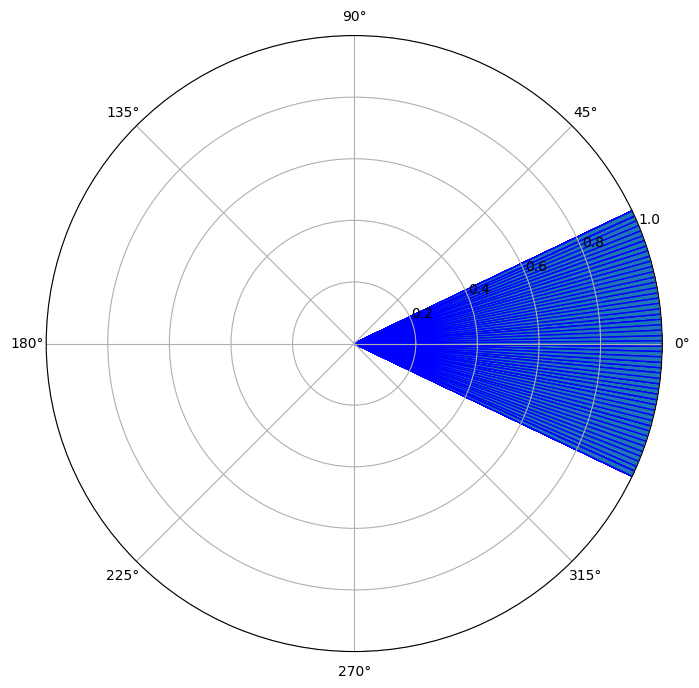

In [340]:
env_dimension=[20,20,20] # env dimensions 20 = 20x20 
colors=["red", "blue", "green", "yellow"] #Bin color, must be equal to env number
pathScreen = r'..\Stats\Screenshot Env'
n_agents = []
df = []   

#cmap
cmap = plt.cm.RdBu
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

# cerca tutti i file Agent Stats presenti nella certella dei log di test di una data run
for nome_file in os.listdir(pathTXT):
        if '.meta' not in nome_file:

                path = os.path.join(pathTXT, nome_file, 'AgentStats.txt')

                df = pd.read_csv(path, decimal=",",
                                delimiter=";",
                                header=None, 
                                names=["Time", "WallTime", "X", "Z", "Group", "Speed","Angle","EnvID","ID", "iteration"])
                
                df = df.reset_index(drop=True)

                # background dell immagine
                bg = os.path.join(pathScreen, nome_file + '.png')
                # os.mkdir(f'../../../LogTraining/{RunID}/Ambienti-Grafici/{env}'


                # IDS = df["ID"] #extracting the agents ids
                # n_agent = len(set(IDS)) # extracting uniique ids
                # aoi = areas_of_interest[0]

                #df['X'] = df['X'].astype(float)
                #df['Z'] = df['Z'].astype(float)

                # new_df = df.loc[(df['posX']>aoi[0]) & (df['posX']<aoi[1]) & (df['posX']>aoi[2]) & (df['posX']<aoi[3])]

                df['iteration'] = df['iteration'].astype(int)
                df['X'] = df['X'].round(2)
                df['Z'] = df['Z'].round(2)
                df['Speed'] = df['Speed'].round(2)
                df['Angle'] = df['Angle'].round(2)
                cleaned_nome_file = nome_file.replace("(Environment)", "").strip()


                linea_zoom(df, bg, cleaned_nome_file)
                lineaSpeed(df,bg, cleaned_nome_file)
                # heatmap(df,bg, cleaned_nome_file) 
                anglePlot(df,bg, cleaned_nome_file) 
                # fondamentaleMIO(df, cleaned_nome_file)

        